# Project 4: Lid Driven Cavity


`Libraries`


In [75]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math

`Initial Variables`


In [76]:
Nx = Ny = 24
l = 1.0
nu = 0.01
velocity = 1.0
Re = 1.0
tf = 1.0
rho = 1

dx = l / Nx
dy = l / Ny

x = np.linspace(0.0, l, Nx+2)
y = np.linspace(0.0, l, Ny+2)
X,Y = np.meshgrid(x,y)
error = []

In [77]:
dt = min(0.25*(min(dx, dy)**2)/nu, (4*nu)/(velocity**2))/2
ts = math.ceil(tf/dt)
dt = tf/ts

`Coefficients`


In [78]:
u_dash = np.zeros([Nx+2, Ny+2])
v_dash = np.zeros([Nx+2,Ny + 2])
p_rhs = p_dash = np.zeros([Nx+2, Ny+2])

In [79]:
u,v,p = [],[],[]
u.append(u_dash)
v.append(v_dash)
p.append(p_dash)

In [80]:
Ap = np.zeros([Ny+2, Nx+2])
Ae = np.ones([Ny+2, Nx+2])*(1/(dx*dx))
Aw = np.ones([Ny+2, Nx+2])*(1/(dx*dx))
An = np.ones([Ny+2, Nx+2])*(1/(dy*dy))
As = np.ones([Ny+2, Nx+2])*(1/(dy*dy))

Aw[:, 1] = 0
Ae[:, -2] = 0
An[-2, :] = 0
As[1, :] = 0

Ap = -(Aw + Ae + An + As)


In [81]:
def pressure_correction(p, b):
    beta = 1.1
    i = 0
    ϵ = 1e-4
    err=1000
    while err > ϵ and i <100:
        p_old = p.copy()
        for i in range(1, Nx+1):
            for j in range(1, Ny+1):
                prhs = b[j, i] - (Ae[j, i]*p[j, i+1] + Aw[j, i]*p[j, i-1] + An[j, i]*p[j+1, i] + As[j, i]*p[j-1, i])
                p[j, i] = beta*(prhs/Ap[j, i]) + (1 - beta)*p[j, i]
        err = np.linalg.norm(p - p_old,2)
        error.append(err)
        i += 1
    return p

In [82]:
def u_predictor(u_star, v_star):
    u_prime = np.zeros([Ny+2, Nx+2])
    for i in range(2, Nx+1):
        for j in range(1, Ny+1):
            ue = 0.5*(u_star[j, i+1] + u_star[j, i])
            uw = 0.5*(u_star[j, i] + u_star[j, i-1])
            un = 0.5*(u_star[j, i] + u_star[j+1, i])
            us = 0.5*(u_star[j, i] + u_star[j-1, i])
            vn = 0.5*(v_star[j+1, i] + v_star[j+1, i-1])
            vs = 0.5*(v_star[j, i] + v_star[j, i-1])
            conv = -(ue*ue - uw*uw)/dx - (un*vn - us*vs)/dy
            diff = nu*((u_star[j, i+1] - 2*u_star[j, i] + u_star[j, i-1])/(dx*dx) + (u_star[j+1, i] - 2*u_star[j, i] + u_star[j-1, i])/(dy*dy))
            u_prime[j, i] = (conv + diff)*dt + u_star[j, i]
    return u_prime

def v_predictor(u_star,v_star):
    v_prime = np.zeros([Ny+2, Nx+2])
    for i in range(1, Nx+1):
        for j in range(2, Ny+1):
            ve = 0.5*(v_star[j, i] + v_star[j, i+1])
            vw = 0.5*(v_star[j, i] + v_star[j, i-1])
            vn = 0.5*(v_star[j, i] + v_star[j+1, i])
            vs = 0.5*(v_star[j, i] + v_star[j-1, i])
            uw = 0.5*(u_star[j, i] + u_star[j-1, i])
            ue= 0.5*(u_star[j, i+1] + u_star[j-1, i+1])
            conv = -(ue*ve - uw*vw)/dx - (vn*vn - vs*vs)/dy
            diff = nu*((v_star[j, i+1] - 2*v_star[j, i] + v_star[j, i-1])/(dx*dx) + (v_star[j+1, i] - 2*v_star[j, i] + v_star[j-1, i])/(dy*dy))
            v_prime[j, i] = (conv + diff)*dt + v_star[j, i]
    return v_prime

In [83]:
t = 0
while t < tf:
    u_star = u[-1]
    v_star = v[-1]
    p_star = p[-1]

    # Boundry condtions of u
    u_star[:, 1] = 0
    u_star[:, -1] = 0
    u_star[-1, :] = 2*velocity- u_star[-2, :]
    u_star[0, :] = 0 - u_star[1, :]
    
    # Boundary conditions of v
    v_star[-1, :] = 0
    v_star[1, :] = 0
    v_star[:, 0] = 0 - v_star[:, 1]
    v_star[:, -1] = 0 - v_star[:, -2]

    
    u_val = u_star.copy()
    v_val = v_star.copy()

    # predictor for velocity
    u_prime = u_predictor(u_star, v_star)
    # print(np.shape(u_prime))
    v_prime = v_predictor(u_star, v_star)

    # correction using predicted values
    for i in range(1, Nx+1):
        for j in range(1, Ny+1):
            p_rhs[j, i] = ((u_prime[j, i+1] - u_prime[j, i])/dx + (v_prime[j+1, i] - v_prime[j, i])/dy)
    p_rhs = p_rhs/dt
    p_prime = pressure_correction(p_star,p_rhs)

    # velocity correction
    u_val[1:-1, 2:-1] = u_prime[1:-1, 2:-1] - (dt/(rho*dx))*(p_prime[1:-1, 2:-1] - p_prime[1:-1, 1:-2])
    v_val[2:-1, 1:-1] = v_prime[2:-1, 1:-1] - (dt/(rho*dx))*(p_prime[2:-1, 1:-1] - p_prime[1:-2, 1:-1])
    
    u.append(u_val)
    v.append(v_val)
    p.append(p_prime)
    time.sleep(dt)
    t+=dt

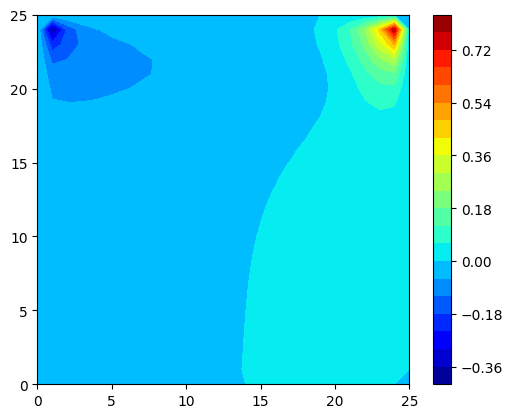

In [84]:
width = 6
plt.figure(figsize = (width, width*0.8))
plt.contourf(p[-1], cmap = plt.cm.jet, levels = 20)
plt.colorbar()
plt.show()

In [85]:
# Extract grid points and centerline indices
x_center_idx = Nx // 2  # Closest to x = 0.5
y_center_idx = Ny // 2  # Closest to y = 0.5

# Extract centerline values from the last timestep
u_x_centerline = u[-1][:, x_center_idx]
v_x_centerline = v[-1][:, x_center_idx]
p_x_centerline = p[-1][:, x_center_idx]

u_y_centerline = u[-1][y_center_idx, :]
v_y_centerline = v[-1][y_center_idx, :]
p_y_centerline = p[-1][y_center_idx, :]

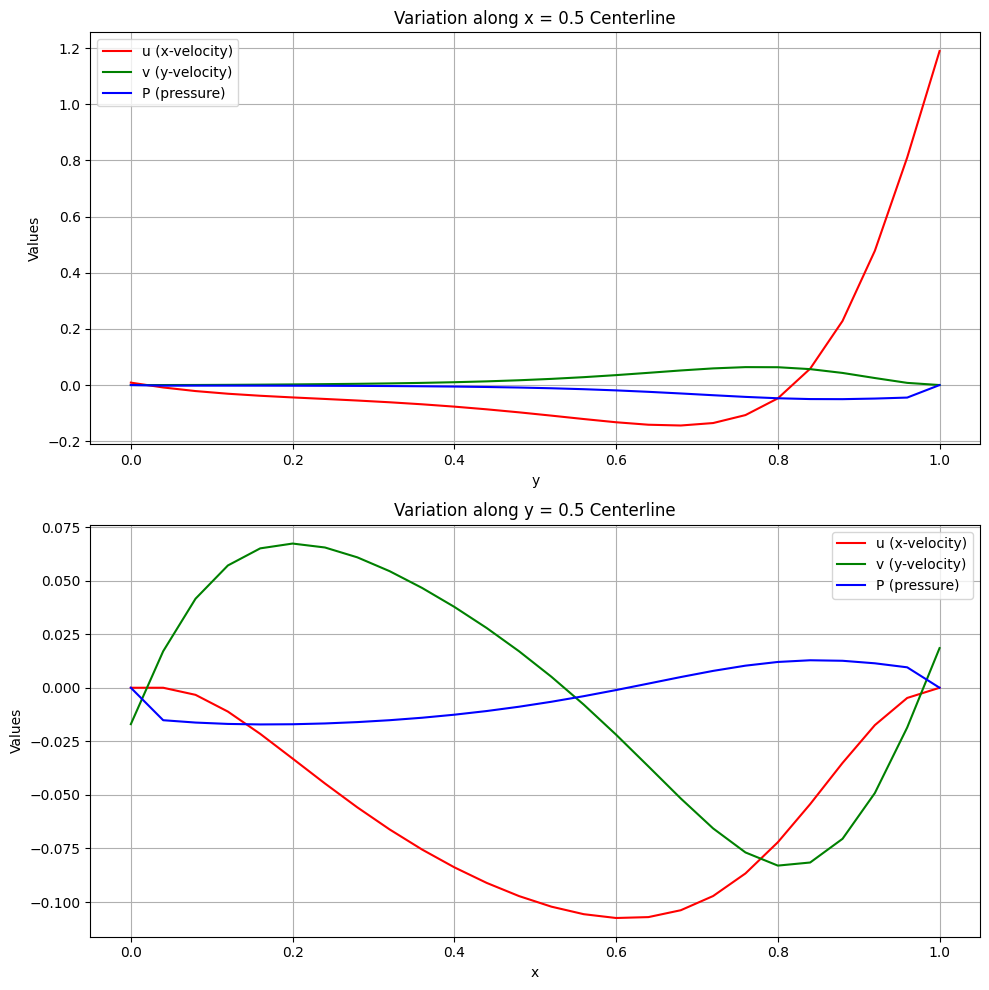

In [86]:


# Plot the variations
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Variation along x = 0.5
axes[0].plot(y, u_x_centerline, label='u (x-velocity)', color='r')
axes[0].plot(y, v_x_centerline, label='v (y-velocity)', color='g')
axes[0].plot(y, p_x_centerline, label='P (pressure)', color='b')
axes[0].set(title='Variation along x = 0.5 Centerline', xlabel='y', ylabel='Values')
axes[0].legend()
axes[0].grid()

# Variation along y = 0.5
axes[1].plot(x, u_y_centerline, label='u (x-velocity)', color='r')
axes[1].plot(x, v_y_centerline, label='v (y-velocity)', color='g')
axes[1].plot(x, p_y_centerline, label='P (pressure)', color='b')
axes[1].set(title='Variation along y = 0.5 Centerline', xlabel='x', ylabel='Values')
axes[1].legend()
axes[1].grid()

plt.tight_layout()


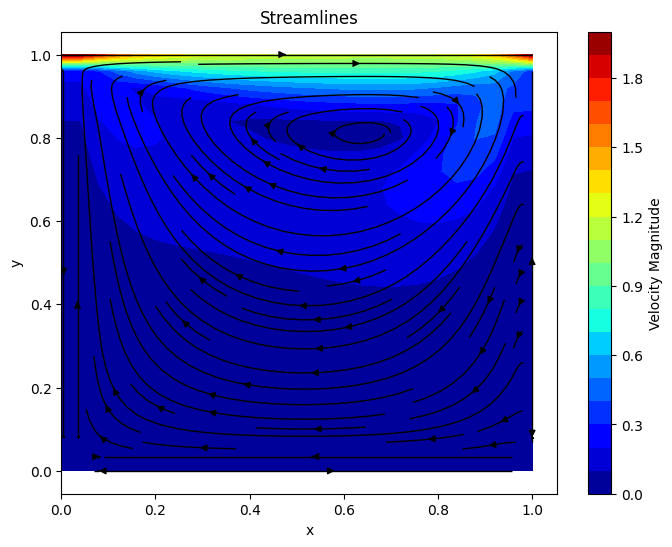

In [87]:
velocity_magnitude = np.sqrt(u[-1]**2 + v[-1]**2)

fig, ax = plt.subplots(figsize=(8, 6))
cont = ax.contourf(X, Y, velocity_magnitude, cmap=plt.cm.jet, levels=20)
ax.streamplot(X, Y, u[-1], v[-1], color='k', linewidth=1)
plt.colorbar(cont, ax=ax, label='Velocity Magnitude')
ax.set(title="Streamlines", xlabel='x', ylabel='y')
plt.show()

In [88]:
import csv

# Open the file in write mode
with open("error_48.csv", mode="w", newline="") as file:
	writer = csv.writer(file)
	# Write the error list to the file
	writer.writerows([[e] for e in error])

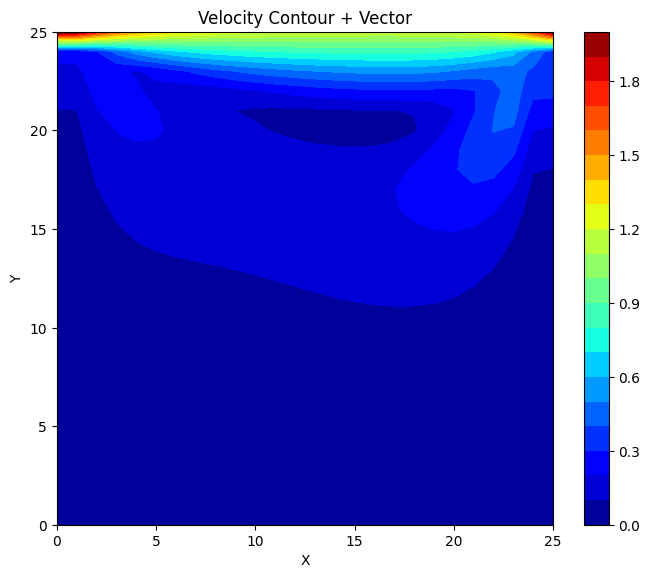

In [ ]:
width = 8
fig, ax = plt.subplots(figsize = (width, width*0.8))
cont = ax.contourf(np.sqrt(u[-1]**2 + v[-1]**2), cmap = plt.cm.jet, levels = 20)
plt.colorbar(cont, ax=ax)
ax.set(xlabel = 'X', ylabel = 'Y', title = 'Velocity Contour + Vector')
plt.show()